In [389]:
import pyspark
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import patches
import numpy as np
import math

In [330]:
sc = pyspark.SparkContext.getOrCreate()

In [331]:
def mapRowACC(idx, file):
    for row in file:
        ts, tp, val1, val2, val3, val4, val5, val6 = row.split(';')
        if tp.strip() == 'ACC':
            yield (int(ts.strip())/1000000.0, norm([float(val1.strip()), float(val2.strip()), float(val3.strip())]))
            
def mapRowGYRO(idx, file):
    for row in file:
        ts, tp, val1, val2, val3, val4, val5, val6 = row.split(';')
        if tp.strip() == 'GYRO':
            yield (int(ts.strip())/1000000.0, (float(val1.strip()), float(val2.strip()), float(val3.strip())))
            
def norm(vals):
    return sum([v**2 for v in vals]) ** 0.5

def simple_lpf(vals, smooth):
    smoothed = list(vals[:1])
    for v in vals[1:]:
        smoothed.append(smoothed[-1] + (v - smoothed[-1]) / smooth)
        
    return smoothed

def average_lpf(vals):
    smoothed = list(vals[:2])
    for v in vals[2:]:
        smoothed.append((v + 2*smoothed[-1] + smoothed[-2]) / 4)
        
    return smoothed

def cumulate(vals):
    vals = list(vals)
    for i in range(1, len(vals)):
        vals[i] = vals[i] + vals[i-1]
        
    return vals

def deltafy(vals):
    vals = list(vals)
    for i in range(len(vals)-1, 0, -1):
        vals[i] = vals[i] - vals[i-1]
    vals[0] = 0
    return vals

In [332]:
FN = './data/corridor_line.csv'
rdd = sc.textFile(FN)

In [333]:
acc = rdd.mapPartitionsWithIndex(mapRowACC)
acc.take(10)

[(968863478.88244, 9.224237979087649),
 (968863481.262811, 9.10352791880538),
 (968863483.6737, 8.949631778968563),
 (968863486.084588, 8.768043244965035),
 (968863488.495477, 8.715992873259363),
 (968863490.906366, 8.69126633693681),
 (968863493.286737, 8.670579150418789),
 (968863495.697626, 8.712512868804843),
 (968863498.108514, 8.720234445434938),
 (968863500.519403, 8.800961304736717)]

In [334]:
acc_normal = acc.collect()

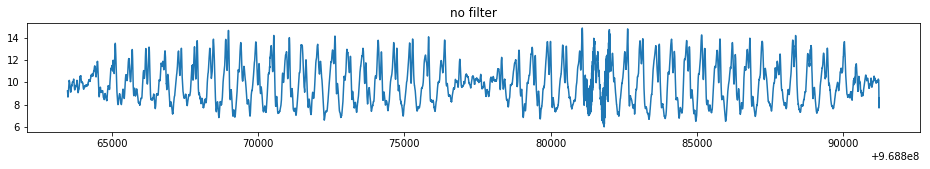

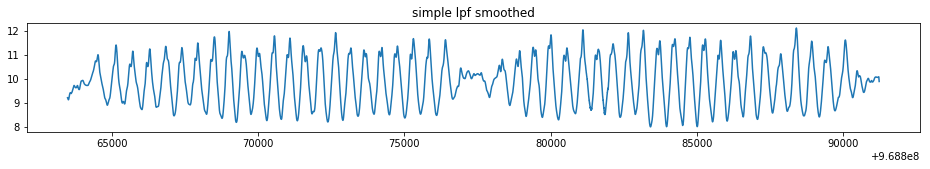

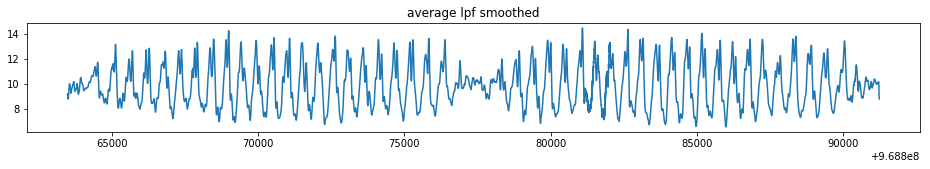

In [378]:
time, acc_mag = zip(*acc_normal)

plt.figure(figsize=(16,2))
plt.plot(time, acc_mag)
plt.title('no filter')
plt.show()

simple_mag = simple_lpf(acc_mag, 50.0)
plt.figure(figsize=(16,2))
plt.plot(time, simple_mag)
plt.title('simple lpf smoothed')
plt.show()

average_mag = average_lpf(acc_mag)
plt.figure(figsize=(16,2))
plt.plot(time, average_mag)
plt.title('average lpf smoothed')
plt.show()

In [428]:
class InertialNavigator:
    M = 3
    QSIZE = 5
    
    G = 9.8
    PEAK_UPPER = 1.6
    PEAK_LOWER = 0.8
    VALL_UPPER = -0.5
    VALL_LOWER = -1.5
    TIME_LOWER = 300
    TIME_UPPER = 1800
    PEAK_INIT = 10.2
    VALL_INIT = 9.5
    
    FREQ_WEIGHT = 0.4
    B1 = 0.55
    B2 = 0.1
    B3 = 0.2
    B4 = 0.1
    
    SMOOTH_PARAM = 50.0
    
    def __init__(self, **kwargs):
        self.last_peak = self.PEAK_INIT
        self.last_vall = self.VALL_INIT
        self.peak_hist = [self.PEAK_INIT] * self.M
        self.vall_hist = [self.VALL_INIT] * self.M
        self.last_peak_t = 0
        self.last_vall_t = 0
        self.found_peak = False
        self.found_vall = False
        self.tmp_peak = None
        self.tmp_vall = None
        self.lpf_val = None
        self.step_t = 0
        self.step_count = 0
        self.step_queue = [0.65]
        self.filter_data = kwargs.get('filter_data', True)
        
    def _update_peak(self, feed_peak):
        new_peak = sum(self.peak_hist) / (self.M * feed_peak) * self.last_peak
        self.last_peak = self._contain_range(new_peak, (self.G+self.PEAK_LOWER, self.G+self.PEAK_UPPER))
        self.peak_hist = self.peak_hist[1:] + [feed_peak]
        
    def _update_vall(self, feed_vall):
        new_vall = sum(self.vall_hist) / (self.M * feed_vall) * self.last_vall
        self.last_vall = self._contain_range(new_vall, (self.G+self.VALL_LOWER, self.G+self.VALL_UPPER))
        self.vall_hist = self.vall_hist[1:] + [feed_vall]
        
    def _contain_range(self, val, r):
        return max(r[0], min(val, r[1]))
    
    def _simple_lpf(self, acc, smooth):
        if not self.lpf_val:
            self.lpf_val = acc
        else:
            self.lpf_val += (acc - self.lpf_val) / smooth
            
        return self.lpf_val
    
    def get_step_count(self):
        return self.step_count
    
    def get_step_length(self):
        return self.step_queue[-1]
    
    def _calculate_step_length(self):
        accpv = self.tmp_peak - self.tmp_vall
        walk_freq = 1.0 / self.step_t
        t1 = self.B1 * (accpv ** 0.25)
        t2 = self.B2 * math.log(accpv)
        t3 = self.FREQ_WEIGHT * (self.B3 * walk_freq + self.B4)
        sl = (1 - self.FREQ_WEIGHT) * (t1 + t2 + t3)
        sl = (sl + np.mean(self.step_queue)) / 2.0
        return 0.65 if sl < 0.5 or sl > 0.8 else sl
        
    def feed_sensor_data(self, data):
        t, acc = data
        
        if self.filter_data:
            smooth_acc = self._simple_lpf(acc, self.SMOOTH_PARAM)
        else:
            smooth_acc = acc
        
        delta_t = t - self.last_peak_t
        if smooth_acc >= self.G+self.PEAK_LOWER:
            if self.found_peak:
                self.tmp_peak = max(self.tmp_peak, acc)
            else:
                if self.TIME_LOWER <= delta_t:
                    self.last_peak_t = t
                    self.tmp_peak = acc
                    
                    if delta_t <= self.TIME_UPPER:
                        self.found_peak = True
                        self.found_vall = False
                    else:
                        self.found_peak = False
                        
        elif smooth_acc <= self.G+self.VALL_UPPER:
            if self.found_vall:
                self.tmp_vall = min(self.tmp_vall, acc)
            else:
                if self.TIME_LOWER <= delta_t:
                    self.step_t = t - self.last_vall_t
                    self.last_vall_t = t
                    self.tmp_vall = acc
                    
                    if delta_t <= self.TIME_UPPER:
                        self.found_vall = True
                    else:
                        self.found_peak = False
                        
        elif self.found_peak and self.found_vall:
            self.step_count += 1
            self.step_queue.append(self._calculate_step_length())
            
            if len(self.step_queue) > self.QSIZE:
                self.step_queue = self.step_queue[-self.QSIZE:]
                
            self._update_peak(self.tmp_peak)
            self._update_vall(self.tmp_vall)
            self.found_peak = False
            self.found_vall = False
            self.tmp_peak = None
            self.tmp_vall = None
            
            return True
        return False
        

In [452]:
inNav = InertialNavigator()
inNav_nosmooth = InertialNavigator(filter_data=False)

for data in acc_normal:
    inNav.feed_sensor_data(data)
    inNav_nosmooth.feed_sensor_data(data)
    
print "Estimated Steps:", inNav.get_step_count() 
print "Unfiltered Estimated Steps:", inNav_nosmooth.get_step_count() 

Estimated Steps: 44
Unfiltered Estimated Steps: 46


In [430]:
gyro = rdd.mapPartitionsWithIndex(mapRowGYRO)
gyro_normal = gyro.collect()

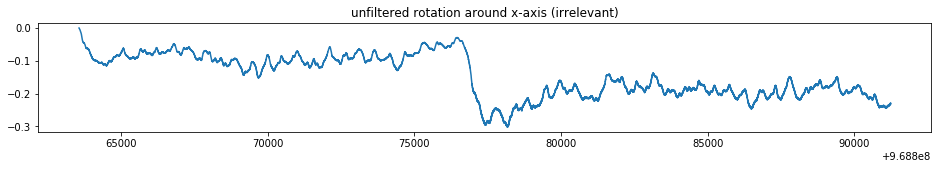

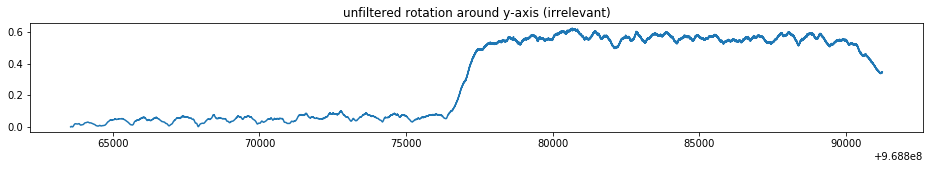

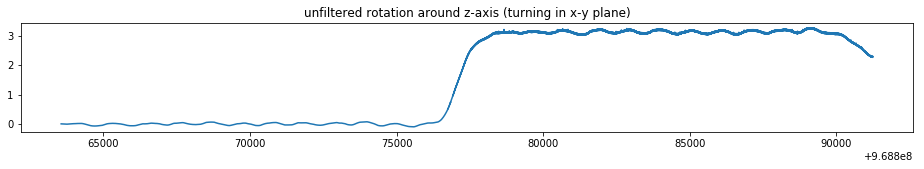

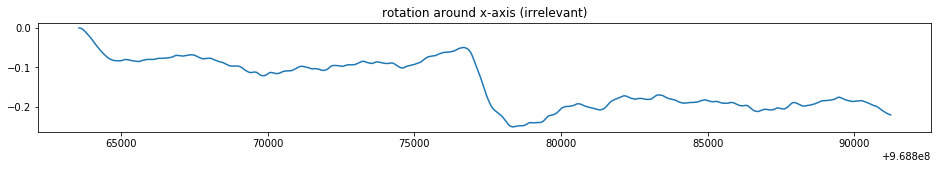

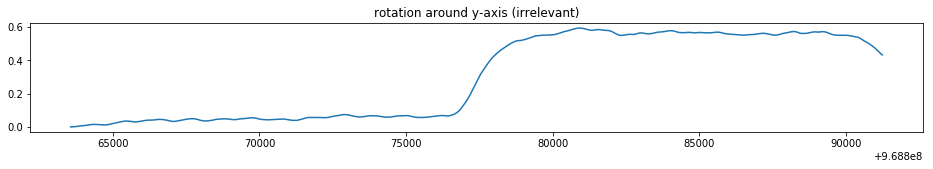

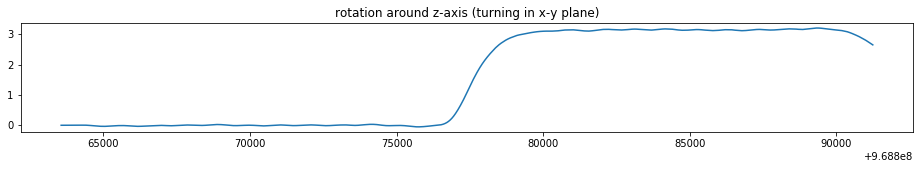

In [471]:
t, angular_change = zip(*gyro_normal)
delta_t = map(lambda x: x / 1000, deltafy(t))
gx, gy, gz = zip(*angular_change)

cgx = np.multiply(delta_t, cumulate(gx))
cgy = np.multiply(delta_t, cumulate(gy))
cgz = np.multiply(delta_t, cumulate(gz))

filtered_cgx = simple_lpf(cgx, 250.0)
filtered_cgy = simple_lpf(cgy, 250.0)
filtered_cgz = simple_lpf(cgz, 250.0)

plt.figure(figsize=(16,2))
plt.plot(t, cgx)
plt.title('unfiltered rotation around x-axis (irrelevant)')
plt.show()

plt.figure(figsize=(16,2))
plt.plot(t, cgy)
plt.title('unfiltered rotation around y-axis (irrelevant)')
plt.show()

plt.figure(figsize=(16,2))
plt.plot(t, cgz)
plt.title('unfiltered rotation around z-axis (turning in x-y plane)')
plt.show()

plt.figure(figsize=(16,2))
plt.plot(t, filtered_cgx)
plt.title('rotation around x-axis (irrelevant)')
plt.show()

plt.figure(figsize=(16,2))
plt.plot(t, filtered_cgy)
plt.title('rotation around y-axis (irrelevant)')
plt.show()

plt.figure(figsize=(16,2))
plt.plot(t, filtered_cgz)
plt.title('rotation around z-axis (turning in x-y plane)')
plt.show()

ERROR: 0.2518472342984847


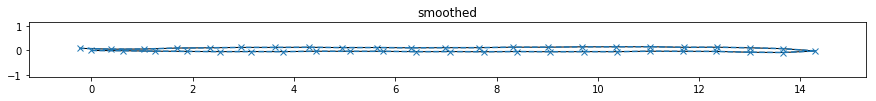

ERROR: 1.4355149953433184


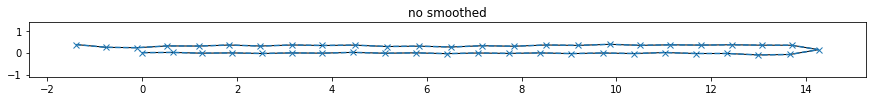

In [469]:
x = [0]
y = [0]
x_nosmooth = [0]
y_nosmooth = [0]
angle_i = 0

inNav = InertialNavigator()
inNav_nosmooth = InertialNavigator(filter_data=False)

for data in acc_normal:
    if data[0] > t[angle_i]:
        angle_i = min(angle_i+1, len(filtered_cgz)-1)
        
    step_detected = inNav.feed_sensor_data(data)
    if step_detected:
        step_length = inNav.get_step_length()
        x.append(x[-1] + step_length * math.cos(filtered_cgz[angle_i]))
        y.append(y[-1] + step_length * math.sin(filtered_cgz[angle_i]))
        
    step_detected = inNav_nosmooth.feed_sensor_data(data)
    if step_detected:
        step_length = inNav_nosmooth.get_step_length()
        x_nosmooth.append(x_nosmooth[-1] + step_length * math.cos(cgz[angle_i]))
        y_nosmooth.append(y_nosmooth[-1] + step_length * math.sin(cgz[angle_i]))
        
fig = plt.figure(figsize=(15, 1))
ax = fig.add_subplot(111)

codes = [Path.MOVETO] + [Path.LINETO] * (len(x) - 1)
coord = zip(x, y)
path = Path(coord, codes)

patch = patches.PathPatch(path, facecolor='white', lw=1)
ax.add_patch(patch)
ax.set_xlim(min(x)-1, max(x)+1)
ax.set_ylim(min(y)-1, max(y)+1)

print "ERROR:", norm([abs(x[0]-x[-1]), abs(y[0]-y[-1])])
ax.plot(x, y, 'x--')
plt.title('smoothed')
plt.show()

fig = plt.figure(figsize=(15, 1))
ax = fig.add_subplot(111)

codes_nosmooth = [Path.MOVETO] + [Path.LINETO] * (len(x_nosmooth) - 1)
coord_nosmooth = zip(x_nosmooth, y_nosmooth)
path_nosmooth = Path(coord_nosmooth, codes_nosmooth)

patch_nosmooth = patches.PathPatch(path_nosmooth, facecolor='white', lw=1)
ax.add_patch(patch_nosmooth)
ax.set_xlim(min(x_nosmooth)-1, max(x_nosmooth)+1)
ax.set_ylim(min(y_nosmooth)-1, max(y_nosmooth)+1)

print "ERROR:", norm([abs(x_nosmooth[0]-x_nosmooth[-1]), abs(y_nosmooth[0]-y_nosmooth[-1])])
ax.plot(x_nosmooth, y_nosmooth, 'x--')
plt.title('no smoothed')
plt.show()
